# IEEE Quantum Summit - Dynamic Circuits
Presented by Thomas Alexander and Michael Healy

**Email**: Thomas.A.Alexander@ibm.com, mbhealy@ibm.com

**Qiskit Slack - #dynamic-circuits**: @quantom, @Michael Healy

**Github**: @taalexander, @mbhealy

<img src="figs/ibm_quantum.png" alt="drawing" style="width:1000px;"/>

Today we will go over some of the new capabilities that are enabled by dynamic circuit support in IBM hardware. This is meant to be an interactive presentation so please don't hesitate to ask any questions you may have! We are really interested in exploring these new and exciting hardware capabilities with our users!

## Preamble

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
shots = 1000

In [2]:
%load_ext autoreload
%autoreload 2

## Getting started with dynamic circuits
Let's start with the basics!

- Q: what are dynamic circuits?
  - A: These are quantum circuits that have control-flow! Think if/else/while, etc., where the predicates are based on the result of previous qubit measurements and the control-flow might be conditionally applying gates.
- Q: Wouldn't you have to do all of this within the qubits lifetime?
  - A: Absolutely! This is one of the core challenges in bringing these capabilities to life. Superconducting qubits have very fast gates but they also have shorter lifetimes. We have designed custom control systems and software at IBM Quantum to make these capabilities possible.
- Q: How do I access these capabilities?
  - A: Look below! The short and sweet is that its nearly the same as any other Qiskit backend.
- Q: What can I do with these capabilities?
  - A: In yesterdays Summit presentations we showed some potential applications of dynamic circuits. In our presentation today we will demonstrate some more of these live.
- Q: What if I have ideas for experiments, hardware capabilities or potentially collaborations?
  - A: We are very interested in hearing more. Please chat with Michael, myself, community team, or one of our client-facing researchers.
- Q: What if I have more questions?
  - A: Please ask throughout the presentation, or check out our [documentation](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/dynamic-circuits/introduction) and especially the [FAQ](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/dynamic-circuits/faq).

### Setting up your local machine
*note*: You will need to have an IBM Quantum account to use the Quantum Lab with access to a dynamic circuit backend.


Log on to IBM Quantum Lab with your IBM Quantum account credentials.

Download the [Dynamic circuits notebooks](https://quantum-computing.ibm.com/lab/files/qiskit-tutorials/dynamic-circuits/), including the ``figs/`` directory.

Next, install Qiskit by following these [instructions](https://qiskit.org/documentation/install.html).

- Setup a Python virtual environment for the tutorial (good practice but not necessary).
- Make sure you have have the latest Qiskit installed. _(`qiskit-terra>=0.22` and the latest Qiskit IBM Provider)_
    - `pip install jupyter matplotlib scipy`
    - `pip install qiskit --upgrade`
    - To update qiskit-terra, run `pip install qiskit-terra -U`
    - `pip install qiskit-ibm-provider`
- Open up this notebook and execute

### Testing OpenQASM 3 Support
Let's test out our installation by verifying we have access to the code and hardware necessary.

First, load our backend.

**Note**: This can be *any* hub/group/project that has access to the required device and the Qiskit runtime and has OpenQASM 3 support. Today we will use a special hub/group/project for summit.

In [3]:
# Running checks for the correct dependencies
import qiskit
from packaging import version

if not(version.parse(qiskit.__qiskit_version__["qiskit-terra"]) >= version.parse("0.22")):
    print(
        "Incorrect dependencies. Found qiskit-terra: "
        + qiskit.__qiskit_version__["qiskit-terra"]
        + "\nNeed qiskit-terra >= 0.22"
    )

try:
    import qiskit_ibm_provider
except ModuleNotFoundError:
    print(
        "You must install the qiskit_ibm_provider with 'pip install qiskit_ibm_provider'"
    )
    raise

In [4]:
# Ignoring warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
# Note: This can be any hub/group/project that has access to the required device and the Qiskit runtime.
# Verify that ``qasm3`` is present in ``backend.configuration().supported_features``.
hub = "ibm-q-internal"
group = "performance"
project = "summit-demos"
hgp = f"{hub}/{group}/{project}"
backend_name = "ibm_peekskill"

Next, we load our IBM Quantum account credentials.

In [58]:
import qiskit
from qiskit_ibm_provider import IBMProvider

# Save token if necessary
# using your standard IQX token.
# IBMProvider.save_account(token='MY_API_TOKEN')

# Get our backend
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
config = backend.configuration()

In [7]:
# Workaround until the `if_else` deployment is fixed.

from qiskit.circuit import IfElseOp

if "if_else" not in backend.target:
    backend.target.add_instruction(IfElseOp, name="if_else")

Make sure to use any OpenQASM 3-enabled backend.

In [8]:
qasm3_backends = set(
    backend.name for backend in provider.backends(dynamic_circuits=True)
)

print(f"The following backends support dynamic circuits: {qasm3_backends}")

The following backends support dynamic circuits: {'alt_auckland', 'ibm_peekskill', 'ibmq_manila', 'ibm_hanoi', 'ibm_washington', 'ibm_geneva', 'ibm_wellington', 'ibm_kawasaki', 'ibmq_kolkata', 'ibm_perth', 'ibm_auckland', 'ibm_oslo', 'simulator_qasm3', 'alt_manila', 'ibmq_dublin', 'ibmq_mumbai', 'ibmq_jakarta'}


## Hello Dynamic Circuit World
For some time IBM Quantum hardware have supported some initial highly-structured dynamic circuit capabilities such as mid-circuit measurements and reset instructions. We have been able to write experiments that use these capabilities in a very straightforward manner through Qiskit. However, these have been the limits of these capabilities as going beyong this required significant redesigns of control-systems and their software stack.

The circuit below prepare a qubit in its excited state, measures it, and then resets the qubit before measuring it again to verify we are capable of resetting the qubit.

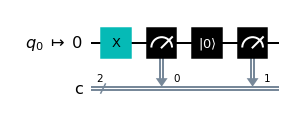

In [9]:
from qiskit import QuantumCircuit, transpile

qc_reset = QuantumCircuit(1, 2)
qc_reset.x(0)
qc_reset.measure(0, 0)
qc_reset.reset(0)
qc_reset.measure(0, 1)

qc_reset = transpile(qc_reset, backend)
qc_reset.draw(output="mpl", idle_wires=False)

With non-dynamic circuits we would execute the circuit with `backend.run`

In [10]:
job_reset = backend.run(qc_reset, shots=shots)
print(f"Job id {job_reset.job_id()}")

Job id cdk0uiq2h6kvivd6vd60


In [11]:
print(f"reset job counts are {job_reset.result().get_counts(0)}")

reset job counts are {'00': 21, '01': 948, '11': 31}


We can run a "dynamic circuit" in much the same way. Just set `dynamic=True`.

Its important to note that this program will traverse a completely new software stack that is designed to scale to support complicated dynamic circuit programs on large-scale systems targeted by our hardware roadmap. Michael will speak more about this software later in our presentation.

In [12]:
job_reset_dynamic = backend.run(qc_reset, shots=shots, dynamic=True)
print(f"Job id {job_reset_dynamic.job_id()}")

Job id cdk0us22h6kvivd6vebg


In [13]:
print(f"reset job counts using the new dynamic circuit path are {job_reset_dynamic.result().get_counts(0)}")

reset job counts using the new dynamic circuit path are {'00': 14, '01': 967, '11': 19}


This really isn't very interesting as we could write this program on the legacy software path, ie., `dynamic=False`.

What we *can* do is write our own definition of a reset instruction using a dynamic circuit. With dynamic circuits we have available to us general forms of structured control-flow such as if/else. The hardware also has available to it a special fast-path for local control-flow between a qubit and its own measurement results that the compiler is able to take advantage of.

Here we use new-style control-flow in Qiskit that allows multiple gates to be conditioned upon in a block, as well as nested control-flow.

*Note*: The visualization of new-style control-flow is still being augmented.

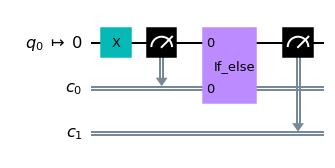

In [14]:
from qiskit import QuantumCircuit, transpile

qc_reset_direct = QuantumCircuit(1, 2)
qc_reset_direct.x(0)
qc_reset_direct.measure(0, 0)
with qc_reset_direct.if_test((0, 1)):
    qc_reset_direct.x(0)
qc_reset_direct.measure(0, 1)

qc_reset_direct = transpile(qc_reset_direct, backend)
qc_reset_direct.draw(output="mpl", idle_wires=False)

In [15]:
job_reset_direct = backend.run(qc_reset_direct, shots=shots, dynamic=True)
print(f"Job id {job_reset_direct.job_id()}")

Job id cdk0v8uh8o8scsh49r2g


In [16]:
print(f"reset job counts using the handwritten reset {job_reset_direct.result().get_counts(0)}")

reset job counts using the handwritten reset {'00': 10, '01': 972, '10': 8, '11': 10}


Here we can see that we achieve the same results with our hand-written reset. Even better the result of the measurement is available to us for additional post-processing. Internally these programs result in exactly the same code being generated in the hardware, however, we can take the hand-written reset and build on it to perform more advanced programs.

# Teleporting a quantum state

One example of a technique that is enabled by having control-flow available in a circuit is
quantum teleportation. 

Visit the Qiskit Textbook to know more about [Quantum teleportation](https://qiskit.org/textbook/ch-algorithms/teleportation.html).

<img src="figs/telamon.jpeg" alt="drawing" style="width:800px;"/>

## Overview of Quantum Teleportation
Alice wants to send quantum information to Bob. Specifically, suppose they want to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

The no-cloning theorem states that you cannot simply make an exact copy of an unknown quantum state. Therefore, Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer their state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

To transfer a quantum bit, Alice and Bob must use a third party to send an entangled pair and then apply the Quantum Teleportation Protocol to "teleport" Alice's qubit to Bob. 

The Qiskit Textbook [Teleportation Section](https://qiskit.org/textbook/ch-algorithms/teleportation.html) provides more detail on the protocol, simulating the protocol and running on IBM hardware using deferred measurement. Here we will execute quantum teleportation on IBM hardware using dynamic circuits.

In [17]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [18]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
# Include a third register for measuring Bob's result
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb = ClassicalRegister(1, name="crb")
qc_teleport = QuantumCircuit(qr, crz, crx, crb)

#### Step 1

Use two qubits to create an entangled Bell pair. Qubit $a$ is given to Alice, qubit $b$ is given to Bob:

In [19]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [20]:
## STEP 1
create_bell_pair(qc_teleport, 1, 2)

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit they are 
trying to send Bob). Then Alice applies a Hadamard gate to $\vert\psi\rangle$. In our quantum circuit, the qubit ($\vert\psi\rangle$) Alice is trying to send is $q_0$:

In [21]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [22]:
## STEP 2
qc_teleport.barrier() # Use barrier to separate steps
alice_gates(qc_teleport, 0, 1)

#### Step 3
Next, Alice applies a measurement to both qubits that they own,  $q_1$,  $\vert\psi\rangle$, and stores this result in two classical bits. They then send these two bits to Bob.

In [23]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [24]:
measure_and_send(qc_teleport, 0, 1)

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [25]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use qc.if_test to control our gates with a classical
    # bit instead of a qubit
    with qc.if_test((crx, 1)):
        qc.x(qubit)
    with qc.if_test((crz, 1)):
        qc.z(qubit)

In [26]:
## STEP 4
qc_teleport.barrier() # Use barrier to separate steps
bob_gates(qc_teleport, 2, crz, crx)

#### Step 5

Finally, Bob measures their qubit to verify the teleportation of Alice's qubit state.

In [27]:
## STEP 5
crb = ClassicalRegister(1, name="crb")
qc_teleport.measure(2,2);

### Full quantum teleportation circuit

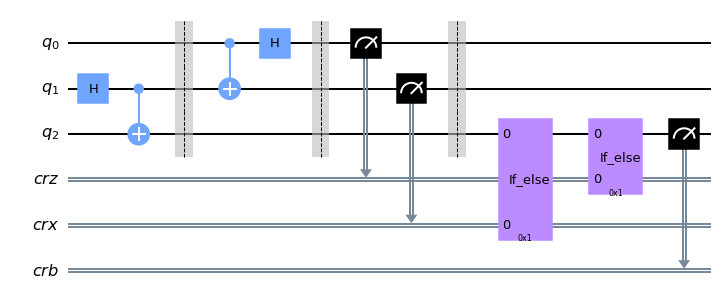

In [28]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
# include third register for measuring Bob's result
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb = ClassicalRegister(1, name="crb")
qc_teleport = QuantumCircuit(qr, crz, crx, crb)

## STEP 1
create_bell_pair(qc_teleport, 1, 2)

## STEP 2
qc_teleport.barrier() # Use barrier to separate steps
alice_gates(qc_teleport, 0, 1)

## STEP 3
measure_and_send(qc_teleport, 0, 1)

## STEP 4
qc_teleport.barrier() # Use barrier to separate steps
bob_gates(qc_teleport, 2, crz, crx)

## STEP 5
crb = ClassicalRegister(1, name="crb")
qc_teleport.measure(2,2)
qc_teleport.draw(output="mpl", cregbundle=False) # suppress RuntimeWarning with cregbundle=False 

In [29]:
qc_teleport_transpiled = transpile(qc_teleport, backend)

### Teleport the excited state

We will now place Alice's qubit in the excited state prior to running the protocol. In this case we should now measure $\vert1\rangle$ with a probability approaching 1.

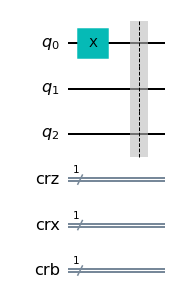

In [30]:
# create an circuit with an excited qubit with the same structure as our teleportation circuit
qr2 = QuantumRegister(3, name="q")
crz2, crx2 = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb2 = ClassicalRegister(1, name="crb")
qc_excited = QuantumCircuit(qr2, crz2, crx2, crb2 )
qc_excited.x(0)
qc_excited.barrier()
qc_excited.draw(output="mpl")

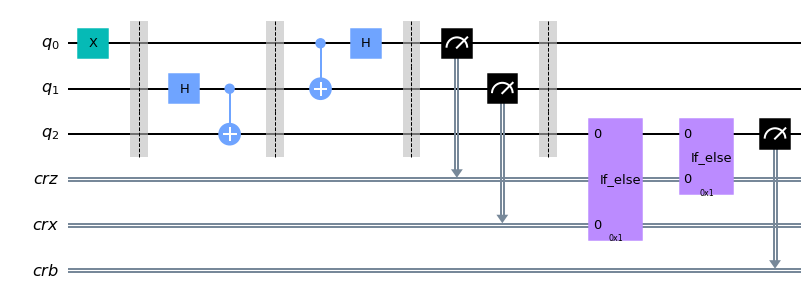

In [31]:
qc_teleport_excited = qc_excited.compose(qc_teleport)
qc_teleport_excited.draw(cregbundle=False, output="mpl")

In [32]:
# transpile, run and plot results
qc_teleport_excited_transpiled = transpile(qc_teleport_excited, backend)
# run job 
shots = 1000
job_teleport = backend.run(qc_teleport_excited_transpiled, shots=shots, dynamic=True)
print(f"Job ID: {job_teleport.job_id()}")

Job ID: cdk11qlf14jb6brc9950


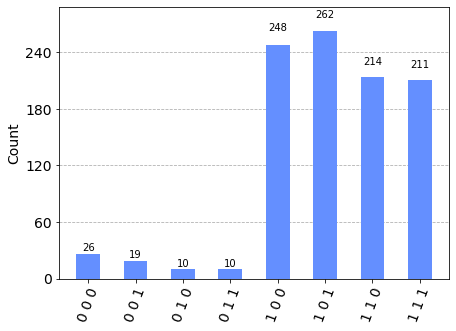

In [33]:
from qiskit.visualization import plot_histogram

# Get the results and display them
result_teleport = job_teleport.result()
counts_teleport = result_teleport.get_counts()
plot_histogram(counts_teleport)

The results returned from our job have keys with the most recent measurement in the most significant bit. These are in the form of 'crb, crx, crz' where crb is Bob's measurement. To get Bob's results, we need to trace out the results from the crx and crz measurements by summing all the results when Bob measured $\vert0\rangle$, and compare with the results when Bob measured $\vert1\rangle$. We may use the `marginal_counts` method from `qiskit.result` to get Bob's results.

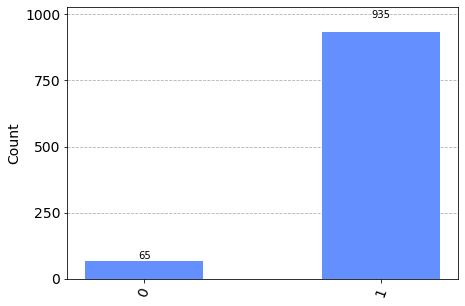

In [34]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts
bobs_qubit = 2
bobs_counts = marginal_counts(counts_teleport, [bobs_qubit])
plot_histogram(bobs_counts)

In [35]:
print(f"The experimental error rate : {bobs_counts['0']*100/sum(bobs_counts.values()):.3f}%")

The experimental error rate : 6.500%


## What is happening behind the scenes to enable dynamic circuits?
Michael will now give us a presentation on the technologies behind our compiler and control-systems that are enabling the dynamic circuit capabilities we see today.

## Repeat Until Success
Let's continue with another demo. We will use conditional gates and measurements to perform repeat until success 

For this tutorial, we will build an abstract circuit that uses the non-parametrized gate set $\{H,\,X,\,S,\,\text{Toffoli}\}$ to construct a heralded $R_X(\theta)$ gate on a target qubit, where $\theta$ satisfies $\cos\theta = \frac35$.  This example is modified slightly from Nielsen and Chuang, _Quantum Computation and Quantum Information_, 10<sup>th</sup> anniversary edition, exercise 4.41.  Each iteration of the circuit only has a finite chance of success, but successes are heralded, so we will use our dynamic-circuit capabilities to repeat the setup until it succeeds.

We first initialize our circuit in Qiskit.  We will create the probabalistic $R_X(\theta)$ gate on one qubit, using two auxiliary controlling qubits, which we will measure throughout the execution of the circuit.  We begin by creating separate quantum and classical registers for these components.

In [36]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

max_trials = 2

controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

qc_repeat_base = QuantumCircuit(controls, target, mid_measure, final_measure)

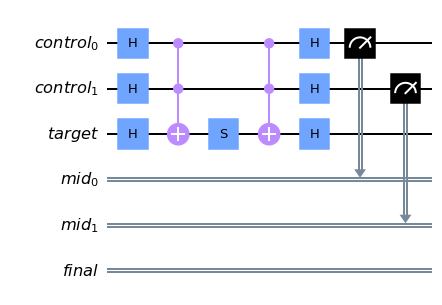

In [37]:
def trial(circuit, target, controls, measures):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)

qc_repeat_example = qc_repeat_base.copy_empty_like()
trial(qc_repeat_example, target, controls, mid_measure)
qc_repeat_example.draw("mpl", cregbundle=False)

If _both_ measurements of the control bits return $0$, the applied gate is $R_X(\theta)$ with $\cos\theta = \frac35$.  If any of the measurements are $1$, then the applied gate is simply $X$, which is a failure.  This is our heralding; we can tell from the measurement whether we applied the correct gate, without disturbing the coherence of the target qubit.  Without fully reproducing the mathematics, the success probability of this gate is:
$$
P_{\text{success}} = \frac{{\lvert 3 + i\rvert}^2}{{\lvert 3 + i\rvert}^2 + 3{\lvert 1 - i\rvert}^2} = \frac58
$$

If there is a failure, we should reset the dirty state, and start again.  Since we know what is applied in the case of a failure, we can use this knowledge to perform the reset efficiently, without using a general hardware reset. For the two auxiliary qubits, this is just an $X$ gate conditioned on its respective measurement being $1$. Here we see a reuse of the reset capability we started out with.

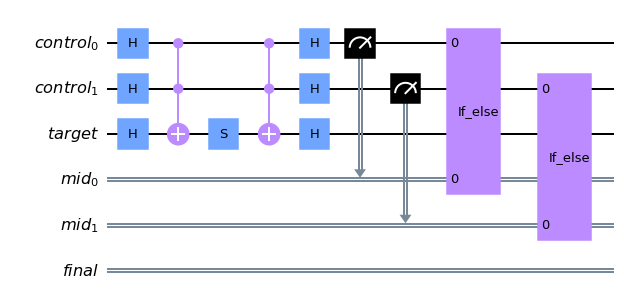

In [38]:
def reset_controls(circuit, controls,  measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])
        
reset_controls(qc_repeat_example, controls, mid_measure)
qc_repeat_example.draw("mpl", cregbundle=False)

So far, we have drawn a dummy circuit, to show the intermediate steps.  Let us now construct the whole circuit in one cell.

We now see the full power of the new-style `with circuit.if_test` blocks compared to the old `c_if` form.  Not only can you include multiple operations in the same single-condition check, but you can also use the `else` branch.  Right now, Qiskit can only represent very basic equality conditions.  The backend is capable of significantly more than this, which you can test out by using the OpenQASM 3 string input forms discussed elsewhere.

Of note is that Qiskit cannot directly represent an _inequality_ condition, which is what we require; we only need to do the repeat if the mid-circuit measurement result was not the bitstring `"00"`.  Instead, we can create an `if` statement with the condition `mid_measure == "00"`, pass an empty block, and then use the `else` branch to perform the logic we want.

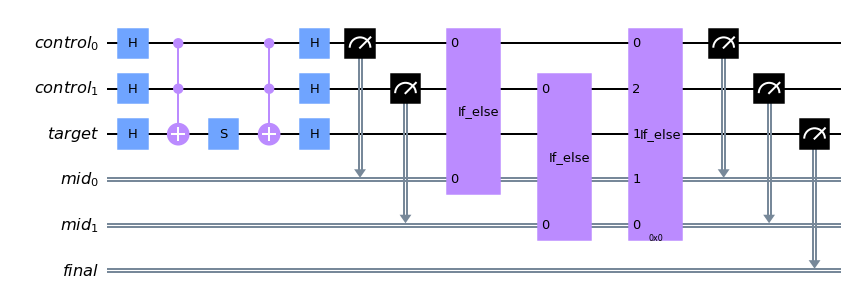

In [39]:
# Create a clean circuit with the same structure (bits, registers, etc)
# as the initial base we set up.
qc_repeat = qc_repeat_base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls
# are guaranteed to start in the |0> state.
trial(qc_repeat, target, controls, mid_measure)

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(qc_repeat, controls, mid_measure)
    with qc_repeat.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        # First reset the target.
        qc_repeat.x(target)
        # Then repeat the trial.
        trial(qc_repeat, target, controls, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
qc_repeat.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
qc_repeat.measure(target, final_measure)

qc_repeat.draw("mpl", cregbundle=False)

All of Qiskit's normal transpilation stages should work with the dynamic circuit: a suitable subset of the available qubits will be chosen; the input gates will all be translated into a basis that the hardware can actually run; the resulting two-qubit gates will be swap-mapped (routed) so that only physically linked qubits are interacted; and the resulting output undergoes some quantum optimizations to remove unnecessary gates and optimize the remaining ones.

By not specifying an `optimization_level` argument to `transpile`, we implicitly use level 1, which has light quantum optimization.  For now, levels 2 and 3 do not support the dynamic circuits path; some of the optimizations used at those levels are not fully control-flow-aware.  For our circuit, the difference is not especially large.

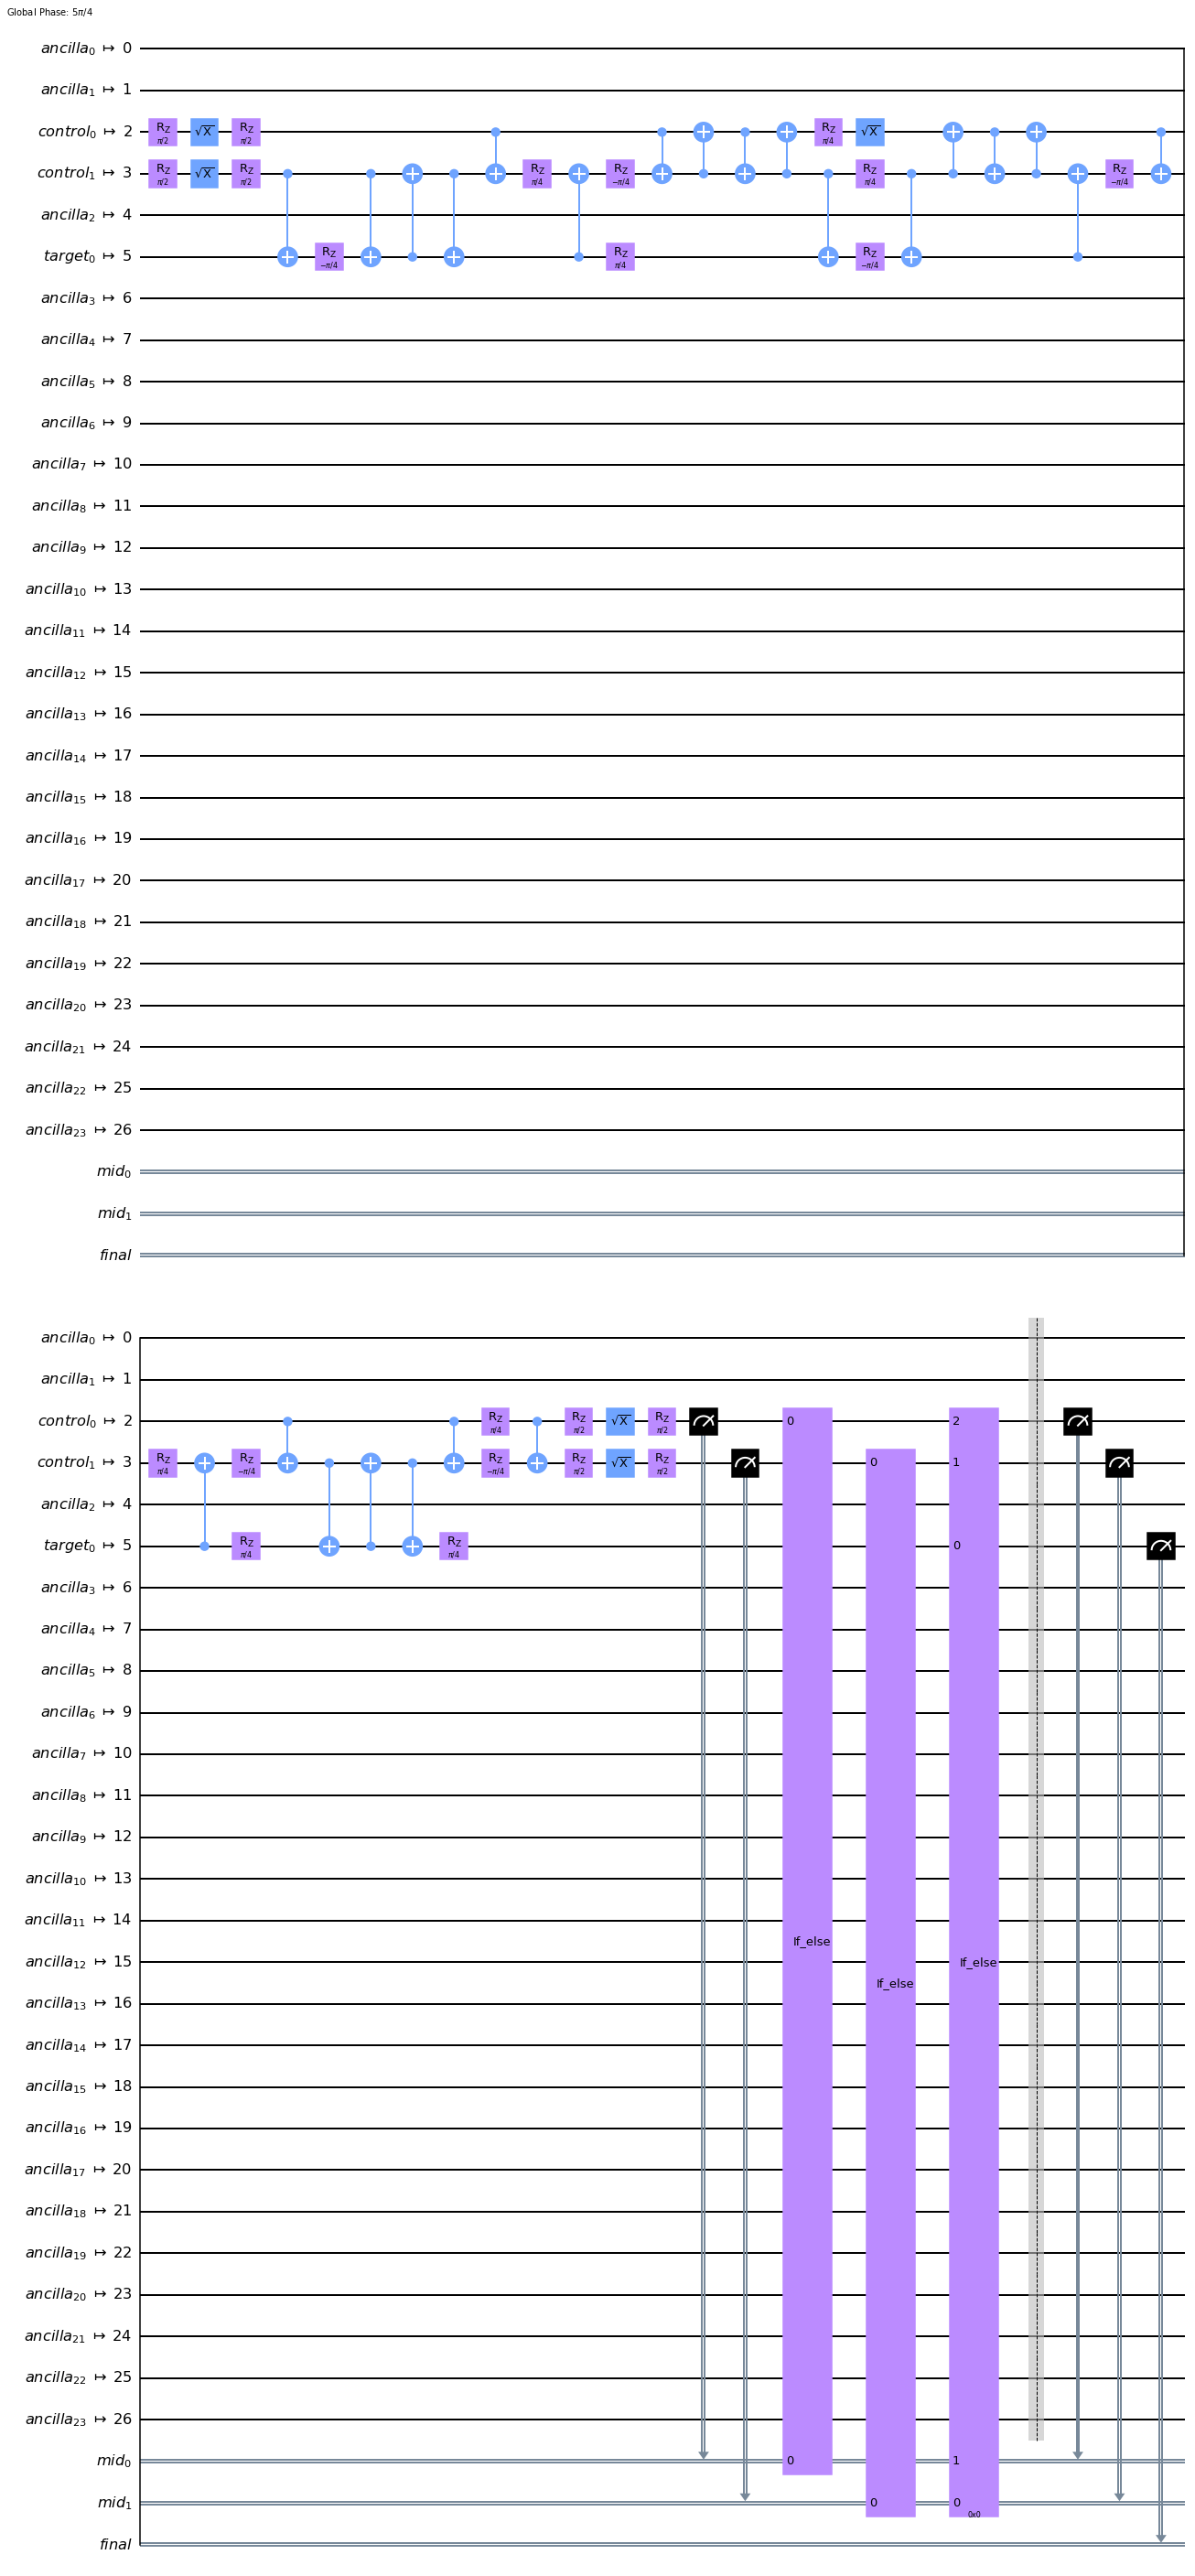

In [40]:
from qiskit import transpile

qc_repeat_transpiled = transpile(qc_repeat, backend)#, initial_layout=repeat_layout)
qc_repeat_transpiled.draw("mpl", cregbundle=False)

Now that we have built the circuit, we execute it on hardware by giving it to the backend's `run` method.  This returns a handle to an asynchronous job object. Calling its result method will block until the result is available, and then return it.

First, though, we can confirm, using Qiskit Aer, that we're producing the results we expect to see.  The preparation has a success probability of $5/8$, and we repeat it up to `max_trials` times, so the probability of a successful result at the end is

$$
P_{\text{success}} = 1 - {\Bigl(1 - \frac58\Bigr)}^{\text{max trials}}
$$

In [41]:
print(f"Probability of success {1 - (1 - 5/8) ** max_trials}")

Probability of success 0.859375


In [42]:
job_repeat = backend.run(qc_repeat_transpiled, dynamic=True, shots=shots)
print(f"Job ID: {job_repeat.job_id()}")

Job ID: cdk12ca2h6kvivd6vsg0


In [43]:
import collections

def marginalize_successes(counts):
    """Split the full output `counts` dictionary
    into two separate dictionaries, marginalizing
    the results to leave only the target qubit's
    state."""
    successes = collections.defaultdict(int)
    failures = collections.defaultdict(int)
    
    for key, value in counts.items():
        if key.endswith("00"):
            successes[key[0]] += value
        else:
            failures[key[0]] += value
            
    return successes, failures

repeat_counts = job_repeat.result().get_counts()
hw_successes, hw_failures = marginalize_successes(repeat_counts)

expected_successes = 1 - (1 - 5/8)**max_trials
actual_successes = sum(hw_successes.values()) / sum(repeat_counts.values())
print(f"Expected success rate {expected_successes:5.3f}.  Actual rate {actual_successes:5.3f}.")

Expected success rate 0.859.  Actual rate 0.414.


We can also test the post-selected output state:

In [44]:
actual_probability = hw_successes["1"] / sum(hw_successes.values())
print(f"Expected |1> probability: 0.2.  Actual probability {actual_probability:5.3f}.")

Expected |1> probability: 0.2.  Actual probability 0.329.


In [45]:
from qiskit_ibm_provider.transpiler.passes.scheduling import DynamicCircuitInstructionDurations, PadDelay, PadDynamicalDecoupling, ALAPScheduleAnalysis


Our final circuit used mid-circuit measurements to do conditional resets and to repeat a trial setup several times, until it either succeeded or the maximum number of trials were exceeded.  This involved several complex dynamic-circuit capabilities:

- Mid-circuit measurements
- Blocks of quantum operations conditioned on mid-circuit measurements
- Conditional measurements
- Dynamical decoupling

## Using OpenQASM3 directly
The preferred path to send a dynamic circuit to IBM Quantum hardware is through `backend.run(program, dynamic=True)`. However, currently Qiskit cannot describe all of the capabilities IBM backend's are capable of such as classical compute, and `extern` function invocations. Similarily, not everyone is using Qiskit and Python, and they may require another way to send programs to the backend.

We are hard at work adding more capability support to Qiskit, however, in the meantime we support accepting OpenQASM 3 programs directly through the `qasm3-runner` Qiskit Runtime program.

Below we import the Qiskit Runtime provider.

In [46]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

import logging.config
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': True,
})


In [47]:

# Temporary overrides.
hgp = "ibm-q-internal/dev-sys-software/internal-test"
backend_name = "ibm_peekskill"

service = QiskitRuntimeService(instance=hgp)
runtime_backend = service.backend(backend_name, instance=hgp)

## We can dump circuits from Qiskit to OpenQASM 3
The exporter has several configuration settings, however, those below are typically valid for IBM Quantum backends.

When debugging your program it is very useful to be able to dump a circuit to a QASM source string.

In [48]:
from qiskit import qasm3

exporter = qasm3.Exporter(disable_constants=True, basis_gates=runtime_backend.configuration().basis_gates)

print(qasm3_reset:=exporter.dumps(qc_reset_direct))

OPENQASM 3;
include "stdgates.inc";
bit[2] c;
x $0;
c[0] = measure $0;
if (c[0] == 1) {
  x $0;
}
c[1] = measure $0;



## Submitting the OpenQASM 3 source string directly to the backend
There are some limitations to submitting source strings directly (such as using the exporter settings above). Please see the dynamic circuit documentation for more info.

In [49]:
from qiskit.providers.ibmq import RunnerResult

runtime_params = {
    "circuits": qasm3_reset,
    "shots": 1000,
}

options = {
    "backend_name": runtime_backend.name,
}

qasm3_reset_job = runtime_backend.service.run(
    program_id="qasm3-runner",
    options=options,
    inputs=runtime_params,
    result_decoder=RunnerResult,
)

print(f"Runtime job id: {qasm3_reset_job.job_id}")

Runtime job id: cdk133aan60ka16a62dg


In [50]:
print(f"The outcome counts from our reset experiment are {qasm3_reset_job.result().get_counts()}")

The outcome counts from our reset experiment are {'0': 16, '1': 965, '10': 9, '11': 10}


## Behind the scenes

![Qiskit Runtime](https://iqx-docs.quantum-computing.ibm.com/_images/Qiskit_Runtime_architecture1.png)

## Currently more capabilities are available through OpenQASM 3 than through Qiskit

Next we see a demo of using extended classical compute capabilities to interplay classical and quantum resources
in real-time on the hardware. We hope that these capabilities will enable a new phase of hardware research.

Note: Classical registers are concatenated together in the results.

In [51]:
classical_compute_qasm3 = """
OPENQASM 3.0;

bit a;
bit b;
bit c;

reset $0; reset $1; reset $2;
barrier $0, $1, $2;
reset $0; reset $1; reset $2;
barrier $0, $1, $2;
reset $0; reset $1; reset $2;
barrier $0, $1, $2;

x $0;
x $2;

a = measure $0; // expected "1"
b = measure $1; // expected "0"
c = measure $2; // expected "1"

bit[3] d = "100";

// Purely classical compute is efficient
if (((a | b) & c) == 1) {
    // Path will nearly always execute 
    d[0] = 1;
} else {
    // Path will rarely execute outside of SPAM errors
    d[0] = 0;
}

bit[3] e = "101";
// Conditionally execute based on classical bit array comparison
// Should always execute
// As it involves a qubit it has a higher latency
if (d == e) {
    x $1;
}

bit final;
final = measure $1; // expected "1"
// Final expected result is '1000000101'
"""

In [52]:
from qiskit.providers.ibmq import RunnerResult

runtime_params = {
    "circuits": classical_compute_qasm3,
    "shots": 1000,
}

options = {
    "backend_name": runtime_backend.name,
}

classical_compute_job = runtime_backend.service.run(
    program_id="qasm3-runner",
    options=options,
    inputs=runtime_params,
    result_decoder=RunnerResult,
)

print(f"Runtime job id: {classical_compute_job.job_id}")

Runtime job id: cdk13v2an60ka16a65q0


In [53]:
print(f"The outcome counts from our classical computer experiment {classical_compute_job.result().get_counts()}")

The outcome counts from our classical computer experiment {'0': 1, '1': 13, '1000000101': 925, '1000000111': 11, '100': 17, '101': 28, '111': 5}


## We can also run arbitrary classical code on the controller
We have the capability to run classical code on the controller written in a purely classical language. The hope is that this will allow us and are users to experiment with efficient hardware decoders, real-time variational techniques
and other experimental techniques such as efficient PEC.

*Note*: This is an early feature and is currently in development.


For example, consider the Rust function below which efficiently evaluates the parity of an integer

```rust
#[no_mangle]
pub extern "C" fn parity(mut x: i64) -> i32 {
  x ^= x >> 32;
  x ^= x >> 16;
  x ^= x >> 8;
  x ^= x >> 4;
  x ^= x >> 2;
  x ^= x >> 1;
  return (x as i32) & 1;
}
```

Or this `decoder` function which maps an input state to its bit-flipped inverse.

```rust
#[no_mangle]
pub extern "C" fn decoder(x: i32) -> i32 {
  match x {
    0 => 7,
    1 => 6,
    2 => 5,
    3 => 4,
    4 => 3,
    5 => 2,
    6 => 1,
    7 => 0,
    _ => 0,
  }
}
```

We are able to interplay these classical computations with our quantum dynaimcs through the OpenQASM3 `extern` subroutine declaration as we show below for the `decoder` function above.

The example below shows how to declare an `extern` function that must be made available
by the backend, casting a bit array of measurement results to an integer and using the
result of this to invoke the `decoder` function and then using this result in a hardware
efficient `switch` statement.

In [54]:
parity_check_qasm3 = """
OPENQASM 3;

// Extern definition
extern decoder(int[32]) -> int[32];

// Initialize our qubits
reset $0; reset $1; reset $2; reset $3; reset $4; reset $5;
barrier $0, $1, $2, $3, $4, $5;

// Prepare the input state |101>
x $0; id $1; x $2;
bit[3] prepare;
// Measure this input state
prepare[0] = measure $0;
prepare[1] = measure $1;
prepare[2] = measure $2;
// The output should be "101"

// Cast the bit array to an integer
int[32] decoder_input;
decoder_input  = prepare;

// Invoke the decoder function and assign the result
int[32] decoded;
decoded = decoder(decoder_input);
// The output should be "010"

// Perform a hardware efficient
// switch. Requiring only one
// communication event in the hardware
// for all possible outcomes.
switch (decoded) {
   case 0: {

   }
   break;
   case 1: {
      x $3;
   }
   break;
   // Should be invoked
   case 2: {
      x $4;
   }
   break;
   case 3: {
      x $3;
      x $4;
   }
   break;
   case 4: {
      x $5;
   }
   break;
   case 5: {
      x $3;
      x $5;
   }
   break;
   case 6: {
      x $4;
      x $5;
   } 
   break;
   case 7: {
      x $3;
      x $4;
      x $5;
   }
   break;
   default: {

   }
   break;
}

bit[3] mapped_parity;
mapped_parity[0] = measure $3;
mapped_parity[1] = measure $4;
mapped_parity[2] = measure $5;
// The output should be "010"
"""

In [55]:
from qiskit.providers.ibmq import RunnerResult

runtime_params = {
    "circuits": parity_check_qasm3,
    "shots": 1000,
}

options = {
    "backend_name": runtime_backend.name,
}

parity_check_job = runtime_backend.service.run(
    program_id="qasm3-runner",
    options=options,
    inputs=runtime_params,
    result_decoder=RunnerResult,
)
print(f"Runtime job id: {parity_check_job.job_id}")

Runtime job id: cdk14ci2h6kvivd704k0


In [56]:
print(f'The correct outcome counts of "010" from our decoder experiment were obtained on {100*parity_check_job.result().get_counts()["10101"]/1000}% of shots')

The correct outcome counts of "010" from our decoder experiment were obtained on 93.7% of shots


## What is happening next?
Moving forward into 2022 and 2023 we will be working with users to explore the hardware's unique capabilities and enable novel experiments through our internal and client-facing research teams. We are laying the foundation to explore quantum computing *at scale* throughout the quantum software and hardware stack.

Some high-priority topics:
- Exposing additional dynamic circuit capabailities through Qiskit, OpenQASM 3 and the qss-compiler
    - Classical compute
    - For/Else/While
    - New more ergonmic program and system-usage APIs
- Producing additional debugging information and documentation of usage and hardware capabilities
- Tuning the performance of the compiler and classical control-systems
   - Scaling up to larger scale systems
- Working on demos and external research collaborations
   - Hardware efficient experiments (VQE, RB, PEC)
   - Quantum error correction
   - Circuit knitting
   - Parametric circuits

We encourage you to checkout our [documentation](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/dynamic-circuits/introduction) for more information. If you want to chat please join our Slack channel at `#dynamic-circuits`. 

The research and community teams are looking for external collaboraters to explore hardware capabilities and to develop dynamic circuit applications.

## Questions? 
We would be happy answer any questions you may have now or offline

**Email**: Thomas.A.Alexander@ibm.com, mbhealy@ibm.com

**Qiskit Slack - #dynamic-circuits**: @quantom, @Michael Healy

**Github**: @taalexander, @mbhealy

<img src="figs/ibm_quantum.png" alt="drawing" style="width:1000px;"/>

In [57]:
import qiskit.tools.jupyter

%qiskit_version_table